# Обучение с учителем: качество модели

В данном проекте мы поможем интернет-магазину 'В один клик' сохранить активность постоянных клиентов, путем подготовки персонализированных предложений для клиентов, чья активность по нашему прогнозу, может снизиться.

Для начала мы изучим данные, предоставленные магазином. Стандартизируем их, удалим дубликаты, разберемся с пропусками.

Далее проведем исследовательских анализ данных. Построим графики по всем признакам, чтобы увидеть, есть ли какие-то аномалии в данных, и если есть, то удалим их.

После этого проведем корреляционный анализ признаков в данных, изучим взаимосвязь между признаками: линейная или нелинейная, присутсвтует ли мультиколлинеарность.

Далее будем создавать модель для прогноза категориального признака - покупательской активности. Создавать модель мы будем при помощи пайплайна, используя различные гиперпараметры, такие как различные модели, а также различные гиперпараметры внутри каждой модели. Таким образом мы найдем оптимальную модель для предсказания.

Как предсказание будет сделано, проведем анализ признаков, выявим, какие признаки наиболее сильно влияют на прогноз.

После того, как у нас будет вся информацию мы посмотрим, чем клиенты с прогнозируемой сниженной активностью отличаются от клиентов с сохранившейся. Найдем сегмент в данных, в которых наиболее заметна просадка, и дадим рекомендации, как это можно исправить.

In [1]:
!pip install phik
!pip install shap
!pip install --upgrade matplotlib==3.5.0
!pip install --upgrade scikit-learn==1.2.2

     |████████████████████████████████| 686 kB 1.7 MB/s eta 0:00:01
     |████████████████████████████████| 539 kB 1.1 MB/s eta 0:00:01
     |████████████████████████████████| 11.2 MB 1.1 MB/s eta 0:00:01
     |████████████████████████████████| 43 kB 2.3 MB/s  eta 0:00:01
     |████████████████████████████████| 4.6 MB 86.5 MB/s eta 0:00:01
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.3.4
    Uninstalling matplotlib-3.3.4:
      Successfully uninstalled matplotlib-3.3.4
     |████████████████████████████████| 9.6 MB 1.8 MB/s eta 0:00:01
     |████████████████████████████████| 301 kB 83.4 MB/s eta 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1


In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

import phik
import shap
from phik.report import plot_correlation_matrix

## 1. Загрузка данных

In [3]:
try:
    market_file = pd.read_csv('/datasets/market_file.csv')
    market_money = pd.read_csv('/datasets/market_money.csv')
    market_time = pd.read_csv('/datasets/market_time.csv')
    money = pd.read_csv('/datasets/money.csv', sep=';', decimal=',')
except:
    market_file = pd.read_csv('C/datasets/ferma_main.csv')
    market_money = pd.read_csv('C/datasets/market_money.csv')
    market_time = pd.read_csv('C/datasets/market_time.csv')
    money = pd.read_csv('C/datasets/money.csv', sep=';', decimal=',')

Посмотрим на наши датафреймы.

In [4]:
market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [5]:
market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [6]:
market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [7]:
money.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


Данные в таблицах соответсвтуют описанию. Колонки в датафреймах правильно разделены, числовые колонки представлены числами.

## 2. Предобработка данных

### 2.1 Змеиный регистр

Названия колонок в датафреймах не соответствуют змениному регистру. Создадим функцию которая это исправит: сдеалает все названия колонок прописными буквами, а пробелы заменит на '_'. Также переименуем столбец 'id' в 'ид', чтобы все колонки были на одном языке.

In [8]:
def snake_register(df):
    '''
    сначала функция удаляет все проблемы в начале и конце строки. потом делает все буквы в нижнем регистре. и потом заменяет 
    оставшиеся пробелы на '_'
    после этого меняем имя колонки 'id' на 'ид'
    '''
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
    df.rename(columns={'id' : 'ид'}, inplace=True)
    return df

Создадим список с нашими датафреймами и применим к ним вышенаписанную функцию.

In [9]:
df_list = [market_file, market_money, market_time, money]
for df in df_list:
    snake_register(df)

### 2.2 Пропуски и дубликаты

Изучим информацию по каждому датафрейму и внесем изменения, если это нужно.

#### 2.2.1 Датафрейм 'market_file'

Посмотрим на количество пропусков в колонках.

In [10]:
market_file.isna().sum()

ид                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
dtype: int64

Пропуски отсутсвтуют, это хорошо.

Теперь посмотрим на значения в категориальных колонках, возоможно там есть опечатки, и из-за этого создались новые классы. Создадим список из колонок со строковыми значениями и выведем уникальные значения для каждой колонки.


In [11]:
columns = ['покупательская_активность', 'тип_сервиса', 'разрешить_сообщать', 'популярная_категория']
for column in columns:
    print(column, ':', market_file[column].unique())

покупательская_активность : ['Снизилась' 'Прежний уровень']
тип_сервиса : ['премиум' 'стандартт' 'стандарт']
разрешить_сообщать : ['да' 'нет']
популярная_категория : ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']


Видно, что в колонке 'тип_сервиса' присутсвует опечатка в слове 'стандартт'. Исправим ее, и после этого проверим датафрейм на дубликаты.

In [12]:
market_file.loc[market_file['тип_сервиса'] == 'стандартт', 'тип_сервиса'] = 'стандарт'
market_file.duplicated().sum()

0

Дубликаты отсутвуют. Преобразования датафрейма 'market_file' выполнены.

#### 2.2.2 Датафрейм 'market_money'

Посмотрим на количество пропусков в колонках.

In [13]:
market_money.isna().sum()

ид         0
период     0
выручка    0
dtype: int64

Пропуски отсутсвтуют, это хорошо.

Посмотрим на уникальные строковые значения в колонке 'период' на наличие опечаток. 

In [14]:
market_money['период'].value_counts()

препредыдущий_месяц    1300
текущий_месяц          1300
предыдущий_месяц       1300
Name: период, dtype: int64

Присутствует три периода, никаких лишних значений нет.

И проверим датафрейм на дубликаты.

In [15]:
market_money.duplicated().sum()

0

Дубликаты отсутсвтуют.

#### 2.2.3 Датафрейм 'market_time'

Посмотрим на количество пропусков в колонках.

In [16]:
market_time.isna().sum()

ид        0
период    0
минут     0
dtype: int64

Пропуски отсутсвтуют, это хорошо.

Посмотрим на уникальные строковые значения в колонке 'период' на наличие опечаток.

In [17]:
market_time['период'].value_counts()

предыдцщий_месяц    1300
текущий_месяц       1300
Name: период, dtype: int64

Есть опечатка в значении 'предыдцщий_месяц'. Исправим ее и проверим датафрейм на наличие дубликатов.

In [18]:
market_time.loc[market_time['период'] == 'предыдцщий_месяц', 'период'] = 'предыдущий_месяц'
market_time.duplicated().sum()

0

Дубликаты отсутсвтуют.

#### 2.2.4 Датафрейм ' money'

Посмотрим на количество пропусков в колонках.

In [19]:
money.isna().sum()

ид         0
прибыль    0
dtype: int64

Посмотрим на количество дубликатов.

In [20]:
money.duplicated().sum()

0

Дубликаты отсутствуют.

### 2.3 Вывод

Предобработка данных выполнена. Все названия колонок были преведены к змеиному регистру. Пропуски  и дубликаты в датафреймах отсутствуют. В датафрейме 'market_file' были исправлены опечатки в значениях в колонке 'тип_сервиса'. В датафрейме 'market_time' также в колонке 'период' были исправлены опечатки в значениях.

## 3. Исследовательских анализ данных

### 3.1 Статистический анализ данных

Посколько основной задачей является сохранение активности постоянных клиентов, то нужно проанализировать данные именно этих клиентов. Постоянными клиентами будем считать тех, у кого покупательская активность состовляет не менее трех месяцев. Отберем таких клиентов и проанализируем данные. В таблице 'market_money' есть данные за 3 периода. Отберем ИД тех клиентов, у которых траты по каждому периоду больше 0.

In [21]:
#создаем список ИД клиентов, у которых в столбце выручка стоит значение больше 0 и количество таких ненулевых периодов - 3
id_const_consumers = market_money.query('выручка > 0').pivot_table(index='ид', values='период', aggfunc='count').query('период == 3').index
len(id_const_consumers)

1297

Теперь обновим наши таблицы, оставив в них только постоянных покупателей.

In [22]:
market_file = market_file[market_file['ид'].isin(id_const_consumers)].reset_index(drop=True)
market_money = market_money[market_money['ид'].isin(id_const_consumers)].reset_index(drop=True)
market_time = market_time[market_time['ид'].isin(id_const_consumers)].reset_index(drop=True)
money = money[money['ид'].isin(id_const_consumers)].reset_index(drop=True)

Данные делятся на числовые и категориальные. Анализ числовых данных мы проведем при помощи функции 'describe()'. А для категориальных данных создадим функцию 'cat_future()'.

In [23]:
#функция принимает датафрейм в качестве аргумента
#создает список с колонками, значения в которых предтавлены типом данных 'object'
#и к каждой такой колонке применяется функция 'value_counts(normalize=True)', чтобы увидеть соотношение значений в колонке.
def cat_future(df):
    cat_col = df.select_dtypes(include='object').columns.tolist()
    for column in cat_col:
        print(df[column].value_counts(normalize=True))
        print()


#### 3.1.1 Таблица 'market_file'.

In [24]:
market_file.describe()

,ид,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
count,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000
mean,215998.986893,4.254433,4.009252,602.993832,0.320547,3.267540,2.841172,4.184271,8.186584
std,374.578554,1.015618,0.696048,249.101456,0.249657,1.354623,1.973451,1.950973,3.977061
min,215349.000000,0.900000,3.000000,121.000000,0.110000,1.000000,0.000000,0.000000,1.000000
25%,215675.000000,3.700000,4.000000,410.000000,0.170000,2.000000,1.000000,3.000000,5.000000
50%,215999.000000,4.200000,4.000000,607.000000,0.240000,3.000000,3.000000,4.000000,8.000000
75%,216323.000000,4.900000,4.000000,806.000000,0.300000,4.000000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.000000,10.000000,9.000000,20.000000


In [25]:
cat_future(market_file)

Прежний уровень    0.61835
Снизилась          0.38165
Name: покупательская_активность, dtype: float64

стандарт    0.710871
премиум     0.289129
Name: тип_сервиса, dtype: float64

да     0.739399
нет    0.260601
Name: разрешить_сообщать, dtype: float64

Товары для детей                        0.253662
Домашний текстиль                       0.192753
Косметика и аксесуары                   0.171935
Техника для красоты и здоровья          0.141095
Мелкая бытовая техника и электроника    0.134156
Кухонная посуда                         0.106399
Name: популярная_категория, dtype: float64



Получилось, что у большинства покупателей (62%) покупательская активность осталась на прежнем уровне. Но 38%, это тоже не мало. Большинство покупателей (71%) имеют стандартный сервис, также большинство согласилось на отправку рекламы о товаре. По категориям покупок распределение примерно равное, но не много лидируют товары для детей (25%), чуть менее популярная категория 'Домашний текстиль', занимающая 19%. Остальные категории занимают от 10% о 17%.
Что касается числовых данных: по маркетиноговым коммуникациям - в месяц приходит в среднем по 4 рекламы на клиента. Среднее время клиента после регистрации составляет 606 дней (практически 2 года). Что касается сайта: в среднем покупатель смотрит 8 страниц за визит сайта, а среднее количество сбоев равно 4, что достаточно много.

#### 3.1.2 Таблица 'market_money'.

In [26]:
market_money.describe()

,ид,выручка
count,3891.000000,3891.000000
mean,215998.986893,5033.718890
std,374.482249,1768.471286
min,215349.000000,2758.700000
25%,215675.000000,4592.000000
50%,215999.000000,4959.000000
75%,216323.000000,5363.200000
max,216647.000000,106862.200000


In [27]:
cat_future(market_money)

препредыдущий_месяц    0.333333
текущий_месяц          0.333333
предыдущий_месяц       0.333333
Name: период, dtype: float64



В данной таблицы равномерно распределены данные о выручке за 3 месяца. Среднемесячная вуручка с одного покупателя составила порядка 5000 рублей.

#### 3.1.3 Таблица 'market_time'.

In [28]:
market_time.describe()

,ид,минут
count,2594.000000,2594.000000
mean,215998.986893,13.340401
std,374.506318,4.081999
min,215349.000000,4.000000
25%,215675.000000,10.000000
50%,215999.000000,13.000000
75%,216323.000000,16.000000
max,216647.000000,23.000000


In [29]:
cat_future(market_time)

текущий_месяц       0.5
предыдущий_месяц    0.5
Name: период, dtype: float64



В данной таблице предоставлены данные о том, сколько минут покупатель провел на сайте за 2 последних месяца. Получилось, что в среднем в месяц покупатель проводит пордяка 13 минут на сайте, а максимально 23 минуты. Что не очень много, учитывая, что это суммарное время за месяц.

#### 3.1.4 Таблица 'money'.

In [30]:
money.describe()

,ид,прибыль
count,1297.000000,1297.000000
mean,215998.986893,3.997610
std,374.578554,1.010813
min,215349.000000,0.860000
25%,215675.000000,3.300000
50%,215999.000000,4.040000
75%,216323.000000,4.670000
max,216647.000000,7.430000


В данной таблице видно, что магазин в среднем получает 4000 рублей прибыли от каждого покупателя.

### 3.2 Визуализация признаков

Для большей наглядности визуализируем признаки, которые выше мы анализировали. Для этого нам понадобятся две функции: функция для визуализации числовых признаков и функция для визуализации строковых признаков. Создадим их.

In [31]:
def cat_feature_plot(df):
    '''
    ФУНКЦИЯ ДЛЯ ОТРИСОВКИ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ
    на вход получает датафрейм
    создает список имен категориальных колонок
    и для каждой колонки строит график countplot()
    если количество уникальных значений в колонке больше 2х, то переворачивает на 90 имена категорий, чтобы ничего не 
    накладывалось друг на друга
    '''
    cat_col = df.select_dtypes(include='object').columns.tolist()  
    
    plt.figure(figsize=(16, 16))
    plt.suptitle('Распределение строковых признаков таблицы', fontsize=14)
    plt.subplots_adjust(left=0.13, 
                    right=0.93, 
                    top=0.93, 
                    bottom= 0.27, 
                    wspace= 0.3, 
                    hspace=0.3)
    c = 1
    for column in cat_col:
        if len(df[column].unique()) >2:
            plt.subplot(4, 4, c)
            plt.ylabel('количество')
            plt.xticks(rotation=90)
            plt.xlabel('')
            sns.countplot(x=df[column])
        else:
            plt.subplot(4, 4, c)
            plt.ylabel('количество')
            plt.xticks(rotation=0)
            plt.xlabel('')
            sns.countplot(x=df[column])
        c+=1
    plt.show()     

In [32]:
def num_feature_plot(df):
    '''
    ФУНКЦИЯ ДЛЯ ОТРИСОВКИ ЧИСЛОВЫХ ПРИЗНАКОВ
    на вход получает датафрейм
    создает список имен числовых колонок, исключая первую 'ид'
    и для каждой колонки строит график boxplot()
    '''
    num_col = df.select_dtypes(exclude='object').columns.tolist()[1:]
    
    plt.figure(figsize=(16, 16))
    plt.suptitle('Распределение числовых признаков таблицы', fontsize=14)
    plt.subplots_adjust(left=0.13, 
                    right=0.93, 
                    top=0.93, 
                    bottom= 0.27, 
                    wspace= 0.3, 
                    hspace=0.3)
    c = 1
    for column in num_col:
        plt.subplot(4, 4, c)
        sns.boxplot(data=df, x=column)
        c+=1
    plt.show()     
    

#### 3.2.1 Таблица 'market_file'.

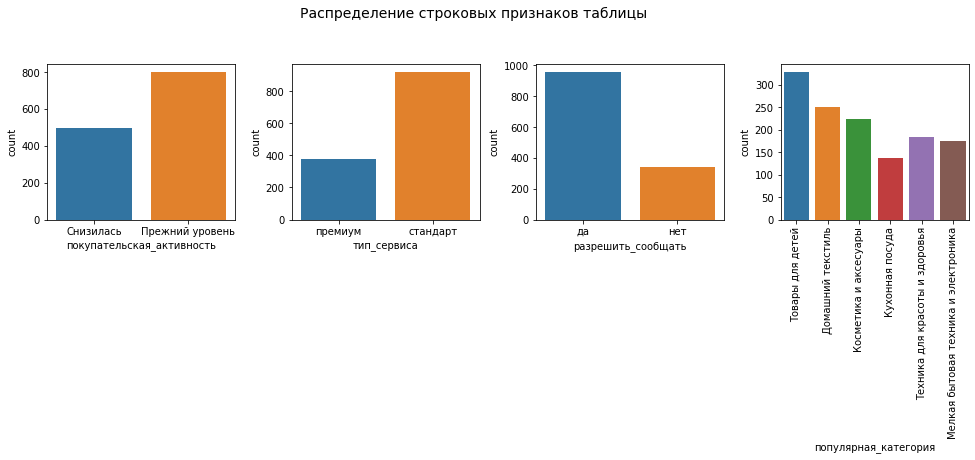

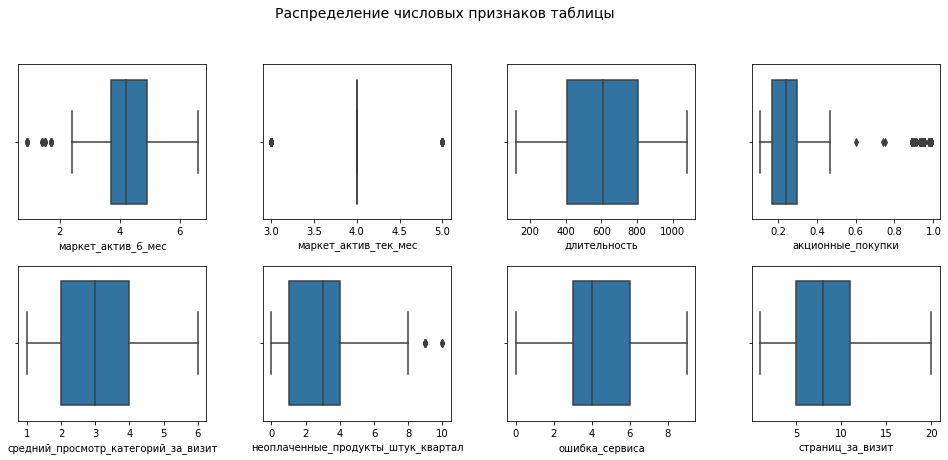

In [33]:
cat_feature_plot(market_file)
num_feature_plot(market_file)

Видно, что присутсвтуют выбросы в некоторых колонках. Есть несколько клиентов, которым практически не поступает рекламных объявлений (1-2 в месяц). Также есть пару клиентов, которым пришло 3 и 5 реклам в текущем месяце, в отличие от общей массы клиентов с 4 рекламами. Видно, что выделяется группа клиентов, корзина которых составляет акционные покупки. Их не очень много, их процент акционных продуктов стремится к 1, т.е. покупают в магазине они что-либо только по акции. Существует также пара клиентов, которые больше 8 раз за последний квартал не оплачивали свои собранные корзины.

#### 3.2.2 Таблица 'market_money'.

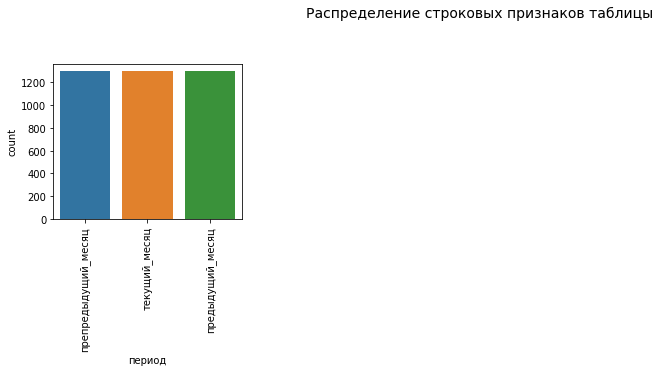

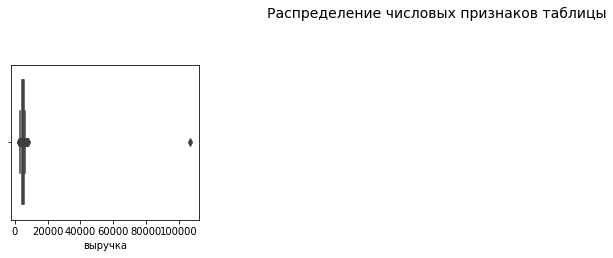

In [34]:
cat_feature_plot(market_money)
num_feature_plot(market_money)

Видно, что выручка от клиентов за период примерно одинаковая и находится в пределах до 10000 рублей, но есть один клиент, выручка от которого составила более 100000 рублей. Возможно это оптовый клиент. Но лучше для дальнейших прогнозов исключить его из списка. Для этого найдем его ИД и исключим из всех списков.

In [35]:
id = market_money[market_money['выручка'] >= 100000].iloc[0, 0]
market_file = market_file[market_file['ид'] != id].reset_index(drop=True)
market_money = market_money[market_money['ид'] != id].reset_index(drop=True)
market_time = market_time[market_time['ид'] != id].reset_index(drop=True)
money = money[money['ид'] != id].reset_index(drop=True)

#### 3.2.3 Таблица 'market_time'.

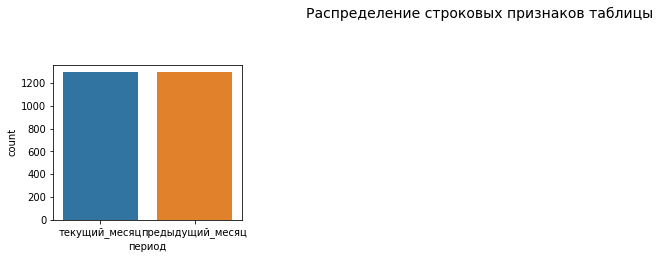

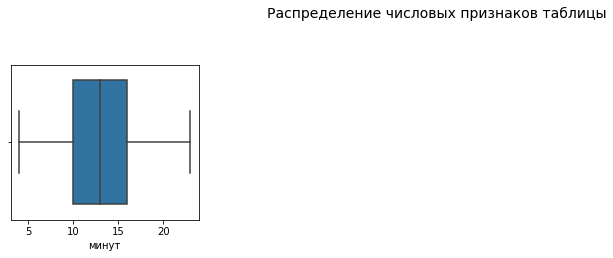

In [36]:
cat_feature_plot(market_time)
num_feature_plot(market_time)

Здесь никаких аномалий и выбросов нет.

#### 3.2.4 Таблица 'money'.

<Figure size 1152x1152 with 0 Axes>

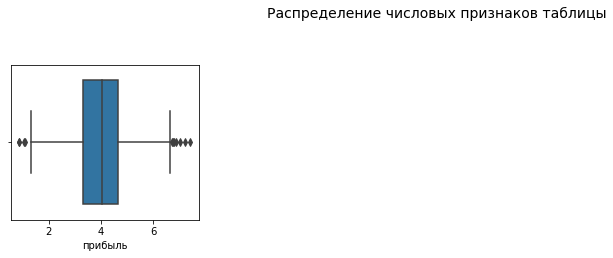

In [37]:
cat_feature_plot(money)
num_feature_plot(money)

Присутсвтуют некоторые выбросы, но ничего критичного.

### 3.3 Вывод

В ходе анализа данных, были исключены непостоянные клиенты, и клиент с аномально высокой прибылью. Значения в таблице 'market_money' равномерно распределены на 3 периода (текущий, прошлый и позапрошлый месяцы). Также как и равномерно распределены данные о времени, которое пользователь провел на сайте (текущий месяц и предыдущий месяц).

У большинства покупателей (62%) покупательская активность осталась на прежнем уровне, у 38% снизилась, и это не мало.. Большинство покупателей (71%) имеют стандартный сервис, также большинство согласилось на отправку рекламы о товаре. По категориям покупок распределение примерно равное, но не много лидируют товары для детей (25%), чуть менее популярная категория 'Домашний текстиль', занимающая 19%. Остальные категории занимают от 10% о 17%.
Что касается числовых данных: по маркетиноговым коммуникациям - в месяц приходит в среднем по 4 рекламы на клиента. Среднее время клиента после регистрации составляет 606 дней (практически 2 года). Что касается сайта: в среднем покупатель смотрит 8 страниц за визит сайта, а среднее количество сбоев равно 4, что достаточно много.

В некоторых колонках присутсвтуют выбросы. Есть несколько клиентов, которым практически не поступает рекламных объявлений (1-2 в месяц). Также есть пару клиентов, которым пришло 3 и 5 реклам в текущем месяце, в отличие от общей массы клиентов с 4 рекламами. Видно, что выделяется группа клиентов, корзина которых составляет акционные покупки. Их не очень много, их процент акционных продуктов стремится к 100, т.е. покупают в магазине они что-либо только по акции. Существует также пара клиентов, которые больше 8 раз за последний квартал не оплачивали свои собранные корзины.

## 4. Объединение таблиц

Для дальнейшей работы создадим одну общую таблицу из таблиц 'market_file', 'market_money' и 'market_time'. Назовем ее 'market'. Но предварительно обработаем таблицы 'market_money' и 'market_time'.  Создадим из них сводные таблицы, в которых будут видны 'выручка' и 'минуты' соотвественно за каждый период.

In [38]:
market_money = market_money.pivot_table(index='ид', columns='период', values='выручка', aggfunc='mean').reset_index()
market_money.columns = ['ид', 'выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц']
market_money.head()

,ид,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц
0,215349,5216.0,4472.0,4971.6
1,215350,5457.5,4826.0,5058.4
2,215351,6158.0,4793.0,6610.4
3,215352,5807.5,4594.0,5872.5
4,215353,4738.5,5124.0,5388.5


In [39]:
market_time = market_time.pivot_table(index='ид', columns='период', values='минут', aggfunc='mean').reset_index()
market_time.columns = ['ид', 'минуты_предыдущий_месяц', 'минуты_текущий_месяц']
market_time.head()

,ид,минуты_предыдущий_месяц,минуты_текущий_месяц
0,215349,12,10
1,215350,8,13
2,215351,11,13
3,215352,8,11
4,215353,10,10


После того как преобразования сделаны, объединим три датафрейма в один.

In [40]:
market = market_file.merge(market_money, on='ид').merge(market_time, on='ид')
market.head()

,ид,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минуты_предыдущий_месяц,минуты_текущий_месяц
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10


## 5. Корреляционный анализ

Создадим матрицу корреляции между признаками различных типов при помощи библиотеки 'phik' и сделаем вывод.

### 5.1 Матрица корреляции

Для начала нужно определиться с колонками с непрервыными значениями. Будем считать такими колонки с данными числовых типов, и чтобы количество уникальных значений в колонке было больше 3.

In [41]:
interval_cols = []
#делаем перебор по колонкам начиная с 1 (чтобы не учитывать колонку ИД)
for  i in market.columns[1:]:
    if (market[i].nunique()>3) and (i in (market.select_dtypes(exclude='object').columns.tolist())):
        interval_cols.append(i)
interval_cols        

['маркет_актив_6_мес',
 'длительность',
 'акционные_покупки',
 'средний_просмотр_категорий_за_визит',
 'неоплаченные_продукты_штук_квартал',
 'ошибка_сервиса',
 'страниц_за_визит',
 'выручка_предыдущий_месяц',
 'выручка_препредыдущий_месяц',
 'выручка_текущий_месяц',
 'минуты_предыдущий_месяц',
 'минуты_текущий_месяц']

In [42]:
# считаем корреляции нашего датафрейма для всего кроме первой колонки (ИД)
phik_overview = market.iloc[:, 1:].phik_matrix(interval_cols=interval_cols)
print(phik_overview.shape)

(17, 17)


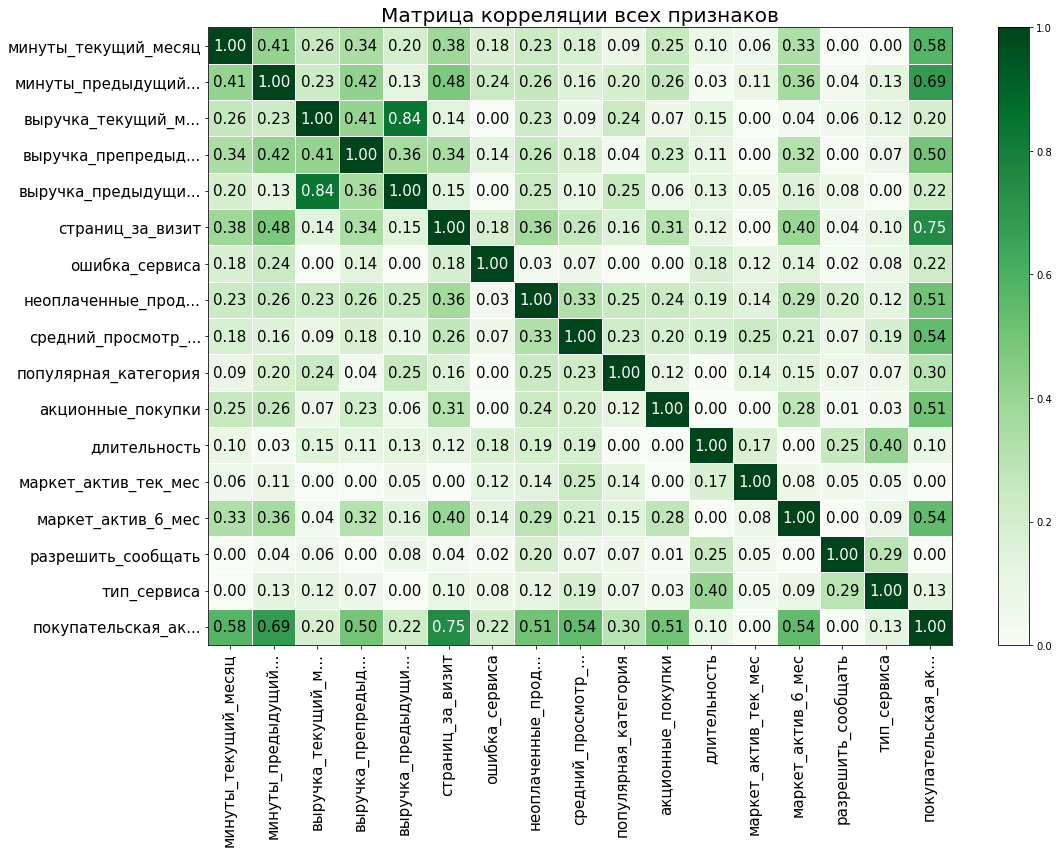

In [43]:
from phik.report import plot_correlation_matrix

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(16, 12)
) 
plt.title('Матрица корреляции всех признаков', fontsize = 20)
plt.show()

### 5.2 Вывод

Мультиколлинеарность между признаками отсутсвует. Наблюдается высокая корреляция (0.84) между выручкой за предыдущий месяц и за текущий. Это связано с тем, что мы рассматриваем постоянных клиентов, а они покупают товары примерно на одинаковые суммы каждый месяц. Также высока корреляция (0.75) между тем, сколько страниц сайта пользователь открыл за визит и его покупательской активностью. Если он открывает много страниц, то вероятно его активность не будет снижаться. Аналогичная ситуация и с временем, проведенным на сайте, там корреляция составляет 0.69. Получается, что взаимодействие с сайтом - это важный элемент, который влияет на покупательскую активность. Чем больше пользователь там проводит времени и чем больше вкладок он открывает, тем больше будет его покупательская активность, поэтому сайту нужно уделять внимание. Что касается маркетинга, то корреляция с покупательской активностью также присутсвтует и составляет 0.54. Получается, большее количество рекламы, помогает поддерживать активность.

## 6. Использование пайплайнов

Спрогнозируем покупательскую активность постоянных клиентов за последующие три месяца. Начнем с подготовки данных. 
Создадим тренировочную и тестовую выборки. Затем созададим списки колонок для различных преобразований. Закодируем целевой признак с помощью LanelEncoder(). И создадим пайплайны. Для поиска лучшей модели воспользуемся метрикой roc_auc. Она лучше accuracy, так как среди признаков присутсвтует много нелинейных.

In [44]:
market.head()

,ид,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минуты_предыдущий_месяц,минуты_текущий_месяц
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10


### 6.1 Поиск лучшей модели и параметров

In [45]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

# загружаем данные
X_train, X_test, y_train, y_test = train_test_split(
    market.drop(['ид', 'покупательская_активность'], axis=1),
    market['покупательская_активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify =  market['покупательская_активность'])

label_encoder = LabelEncoder()
label_encoder.fit(y_train)
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test) 

# создаём списки с названиями признаков
ohe_columns = ['популярная_категория']
ord_columns = ['тип_сервиса', 'маркет_актив_тек_мес', 'разрешить_сообщать']
num_columns = ['маркет_актив_6_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит',
               'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'выручка_предыдущий_месяц', 
               'выручка_препредыдущий_месяц', 'выручка_текущий_месяц', 'минуты_предыдущий_месяц', 'минуты_текущий_месяц']

# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ]
    )
# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),  
     ('ord', ord_pipe, ord_columns),   
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
     # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(3, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 10),
        'models__max_features': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
   
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели SVC()
    {
        'models': [SVC(probability=True, random_state=RANDOM_STATE)],
        'models__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'models__degree' : range(2, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    n_iter=20,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

# проверьте работу модели на тестовой выборке
# рассчитайте прогноз на тестовых данных
y_test_pred = randomized_search.predict(X_test)
y_test_proba = randomized_search.predict_proba(X_test)[:, 1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_proba)}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_fr...
    

Запишем нашу лучшую модель в отдельную переменную

In [46]:
best_model = randomized_search.best_estimator_['models']
best_model

SVC(degree=4, probability=True, random_state=42)

In [47]:
best_model.get_params(deep=True)

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 4,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': True,
 'random_state': 42,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

### 6.2 Вывод

Лучший результат по метрике 'roc_auc' на тестовой выборке получится 0.91. Лучше всего с задачей справилась модель SVM с параметром degree=4. Кодирование категориальных признаков было выполнено при помощи OneHotEncoder и OrdinalEncoder, а числовых при помощи StandardScaler.


## 7. Анализ важности признаков

Посмотрим, как признаки влияют на предсказания. Для этого возьмем нашу лучшую модель. Снова закодируем данные при помощее ранее написанного пайплайна 'data_preprocessor', и визуализируем вклад признаков в предсказание модели.

### 7.1 Визуализация важности признаков

In [48]:
#создаем тренировочные и тестовые входные данные с помощью ранее написанного data_preprocessor. и даем колонки имена
X_train_shap = pd.DataFrame(randomized_search.best_estimator_['preprocessor'].fit_transform(X_train), 
                            columns=randomized_search.best_estimator_['preprocessor'].get_feature_names_out())
X_test_shap = pd.DataFrame(randomized_search.best_estimator_['preprocessor'].transform(X_test), 
                           columns=randomized_search.best_estimator_['preprocessor'].get_feature_names_out())
#обучаем модель
best_model.fit(X_train_shap, y_train)
#взял 20 значений, тк долго высчитывается (около 6 минут).
shap_sample= shap.sample(X_train_shap, 20)

explainer = shap.KernelExplainer(best_model.predict, shap_sample)

shap_values = explainer(X_test_shap)

  0%|          | 0/324 [00:00<?, ?it/s]

In [63]:
randomized_search.best_estimator_['preprocessor']

ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe',
                                 Pipeline(steps=[('simpleImputer_ohe',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['популярная_категория']),
                                ('ord',
                                 Pipeline(steps=[('simpleImputer_before_ord',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ord',
                                                  OrdinalEncoder(...
                                 ['тип_сервиса', 'маркет_актив_тек_мес',
                                  'разрешить_сообщать']),
                                ('num', StandardScaler(),
                                 ['маркет_актив_6_мес', 'длительность',
                                  'акционные_покупки',
                                  'средний_просмотр_категорий_за_визит',
                                  'неоплаченные_продукты_штук_квартал',
                                  'ошибка_сервиса', 'страниц_за_визит',
                                  'выручка_предыдущий_месяц',
                                  'выручка_препредыдущий_месяц',
                                  'выручка_текущий_месяц',
                                  'минуты_предыдущий_месяц',
                                  'минуты_текущий_месяц'])])

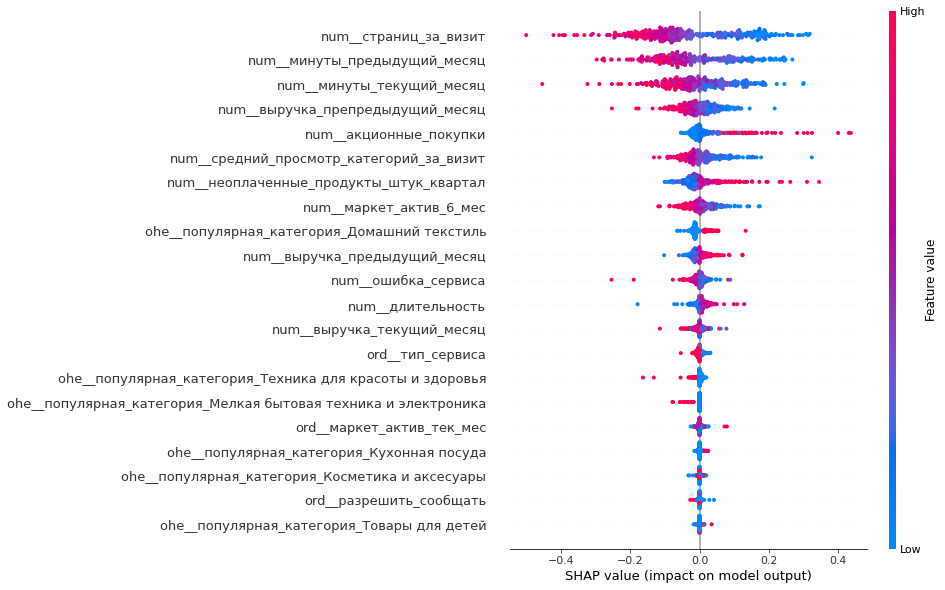

In [49]:
shap.plots.beeswarm(shap_values, max_display=25)

### 7.2 Вывод

In [50]:
print(label_encoder.classes_) 

['Прежний уровень' 'Снизилась']


В нашей кодировке целевого признака 0 класс - это 'прежний уровень', а класс 1 - это 'снизилась'.

Получилось, что для модели мало важны следущие признаки: тип сервиса, выручка (за последние два месяца), и популярные категории товаров.

Сильнее всего на целовой признак влияют следущие параметры: количество страниц, которые пользователь посетил за визит. Чем меньше страниц посетил пользователь, тем вероятнее его покупательская способность будет снижена. С другой стороны, чем больше страниц пользователь открыл, тем вероятнее, что его покупательская активность на прежнем уровне. Близкий с ним параметр, который так же сильно влияет - это количетво минут проведенных на сайте и количество просмотренных категорий. Опять таки, чем меньше пользователь проводит времени, тем ниже его покупательская активность и наоборот. Так же, очень сильно влияет признак 'акционные товары'. Если процент покупок товаров по акции у клиента высок, то скорее всего, это клиент со сниженной покупательной активностью. Видимо он покупает товары, только когда есть акции.

Исходя из этого можно сказать, что сайт очень важен для клиента. И его усовершенсвование может помочь сохранить покупательскую активность у клиентов. Ведь параметры, связанные с сайтом (количество страниц за визит, минуты, проведенные на сайте за месяц, просмотр категорий за визит) наиболее сильно влияют на покупательскую активность. По мимо этого, на клиентов сильно влияет наличие акций. И мы видим, что у многих людей со сниженной покупательской активностью, высокая доля акционных товаров. То есть нужно добавлять количество акций, либо прислылать им индивидуальные предложения, чтобы их завлечь и поддержать эту активность.

## 8. Сегментация покупателей

Спрогнозируем покупательскую активность при помощи нашей лучшей модели на всех данных колонки market и добавим в нашу таблицу колонку с предсказанной активностью. Где 0 - активность осталась на прежнем уровне, 1 - снизилась.

In [51]:
#заново обучим нашу лучшую модель на тренировочных данных
randomized_search.best_estimator_.fit(X_train, y_train)
#данные на анализ модели
X_test_full = market.drop(['ид', 'покупательская_активность'], axis=1)
#и сделаем предсказание на всех данных
predict = randomized_search.best_estimator_.predict(X_test_full)
predict_proba = randomized_search.best_estimator_.predict_proba(X_test_full)[:, 1]
market['предсказанная_покупательская_активность'] = predict
market['предсказанная вероятность_снижения'] = predict_proba
market.head()

,ид,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минуты_предыдущий_месяц,минуты_текущий_месяц,предсказанная_покупательская_активность,предсказанная вероятность_снижения
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10,1,0.977393
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13,1,0.666202
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13,1,0.802430
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11,1,0.956673
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10,1,0.876754


Объединим нашу таблицу 'market' с таблицей 'money' для того, чтобы посмотреть, какой доход ежемесячно приносят нам покупатели. И посмотрим как распределяются доходы в зависимости от группы предсказанной покупательской активности. И после этого можно будет разрабатывать предложение для покупателей со сниженной активностью.

In [52]:
market_full = market.copy()
market_full = market_full.merge(money, on='ид').reset_index(drop=True)
market_full.head()

,ид,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,...,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минуты_предыдущий_месяц,минуты_текущий_месяц,предсказанная_покупательская_активность,предсказанная вероятность_снижения,прибыль
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,...,2,5,5216.0,4472.0,4971.6,12,10,1,0.977393,4.16
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,...,1,5,5457.5,4826.0,5058.4,8,13,1,0.666202,3.13
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,...,6,4,6158.0,4793.0,6610.4,11,13,1,0.802430,4.87
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,...,3,2,5807.5,4594.0,5872.5,8,11,1,0.956673,4.21
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,...,1,4,4738.5,5124.0,5388.5,10,10,1,0.876754,3.95


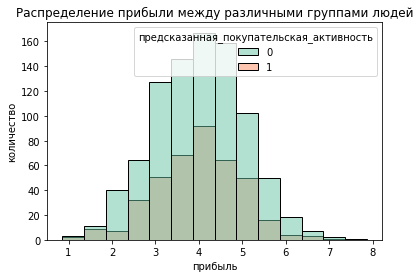

In [53]:
sns.histplot(data=market_full, x='прибыль', hue='предсказанная_покупательская_активность', binwidth=0.5, palette='Set2');
plt.ylabel('количество')
plt.title('Распределение прибыли между различными группами людей')
plt.show()

Видно, что распределение по прибыли в обоих группах похоже на нормальное. Будем рассматривать наиболее часто встречающиеся случаи, где прибыль от клиентов находится между 1 и 3 квантилями.

In [54]:
market_full['прибыль'].describe()

count    1296.000000
mean        3.997701
std         1.011198
min         0.860000
25%         3.300000
50%         4.045000
75%         4.670000
max         7.430000
Name: прибыль, dtype: float64

In [55]:
market_full = market_full[(3.3 <= market_full['прибыль']) & (market_full['прибыль']<= 4.67)]

Посмотрим как распределены покупатели с наиболее популярными значениями прибыли на графике, показывающем вероятность снижения их прибыли.

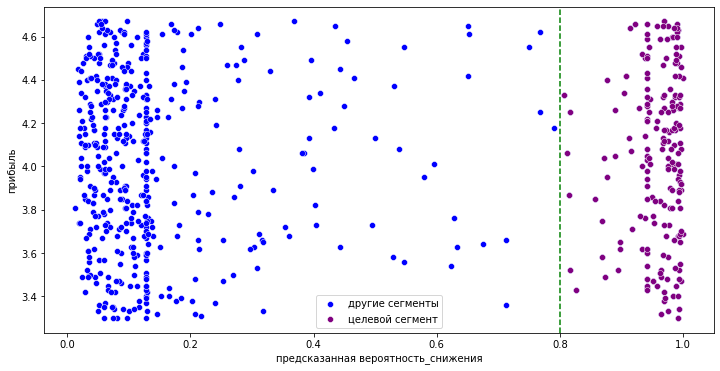

In [56]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=market_full,
                x='предсказанная вероятность_снижения', y='прибыль', label='другие сегменты', color='blue')
sns.scatterplot(data=market_full[market_full['предсказанная вероятность_снижения'] >= 0.8],
                x='предсказанная вероятность_снижения', y='прибыль', label='целевой сегмент', color='purple')
plt.axvline(x=0.8, color='green', linestyle='--')
plt.show()

Видим, что есть отдельный сегмент, начиная с вероятности 0.8, активность которых, скорее всего снизится. И эти клиенты сейчас приносят хорошую выручку. Будем работать с ними.

Создадим новый признак в нашем датафрейме - целевой сегмент. В него войдут покупатели, отмеченные выше на графике фиолетовым цветом. Их значение будет = 1. А у остальных покупателей в этой колонке будет стоят 0.

In [57]:
market_full['целевой_сегмент'] = 0
market_full.loc[market_full['предсказанная вероятность_снижения'] >= 0.8, 'целевой_сегмент'] = 1

Создадим группы признаков. И посмотрим, как эти группы влияют на прибыль.

In [58]:
marketing_vars = ['тип_сервиса', 'разрешить_сообщать', 'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность']
website_vars = ['ошибка_сервиса', 'страниц_за_визит', 'минуты_предыдущий_месяц', 'минуты_текущий_месяц'] 
product_vars = ['популярная_категория', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал']
finance_vars = ['выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц']
vars = [marketing_vars, website_vars, product_vars, finance_vars]

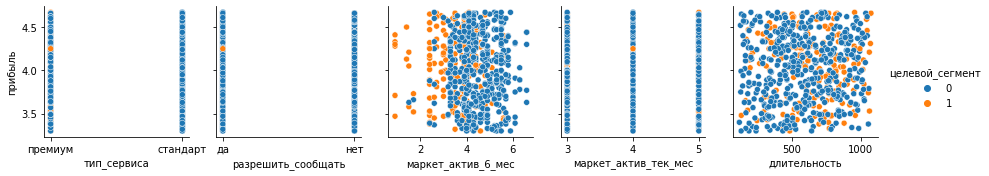

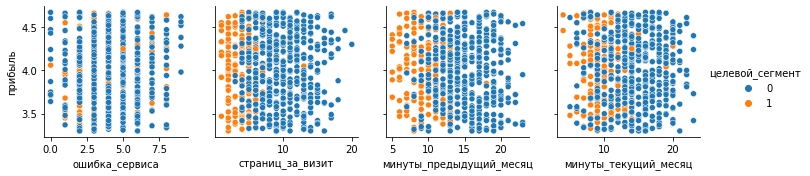

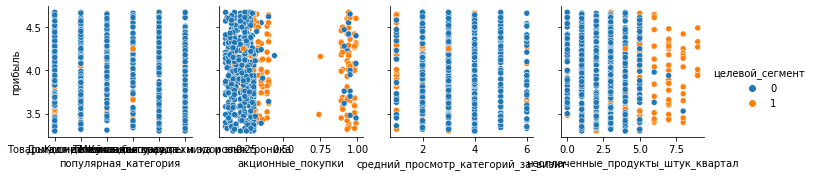

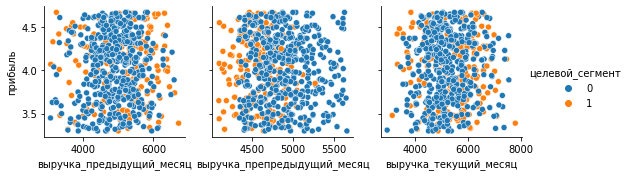

In [59]:
for var in vars:
    g = sns.PairGrid(market_full, hue='целевой_сегмент', x_vars=var, y_vars='прибыль')
    g.map(sns.scatterplot)
    g.add_legend() 
  

Так же создадим отдельный график по распределению между категориями товаров у целевого сегмента и остальных.

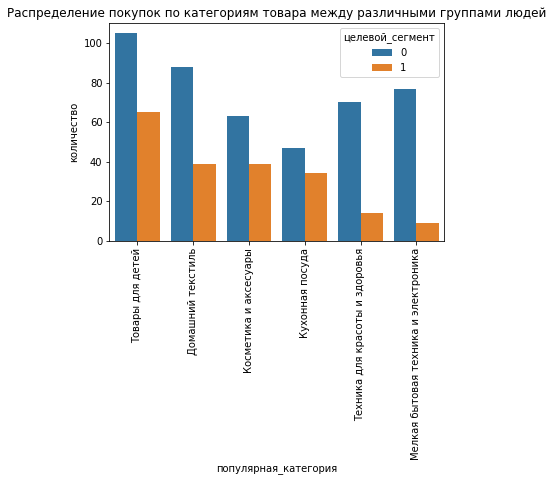

In [60]:
sns.countplot(data=market_full,  x='популярная_категория', hue='целевой_сегмент')
plt.title('Распределение покупок по категориям товара между различными группами людей')
plt.ylabel('количество')
plt.xticks(rotation=90)
plt.show()

По последнему графику видно, что покупатели из целевого, часто покупают товары для детей. Т.е. можно рассматривать этот сегмент для дальнейшей работы по сохранению постоянных клиентов. Из графиков выше видно, что маркетинговая активность за последние 6 месяцев сильно влияет на активность покупателей. Нашему сегменту следует чаще отправлять маркетинговые предложения по категории товаров 'товары для детей'.

Также из графиков выше видно, что много людей со сниженной покупательской активностью, в основном берут товары по акции. Можно выделить эту группу, как отдельный сегмент. Для этой группы следуюет чаще отправлять информацию об акциях и скидках, тогда это поможет сохранить покупательскую активность.

Ниже сохраним эти сегменты в виде списков с ИД покупателей.

In [61]:
goods_for_childrens_segment = market_full.loc[(market_full['целевой_сегмент'] == 1) &
                                              (market_full['популярная_категория'] == 'Товары для детей'), 'ид'].values
goods_for_childrens_segment

array([215349, 215352, 215369, 215373, 215375, 215377, 215379, 215389,
       215394, 215402, 215410, 215416, 215417, 215422, 215432, 215433,
       215436, 215441, 215447, 215452, 215453, 215457, 215461, 215480,
       215481, 215489, 215518, 215521, 215525, 215527, 215539, 215541,
       215546, 215556, 215579, 215581, 215590, 215592, 215594, 215598,
       215616, 215623, 215626, 215628, 215631, 215636, 215641, 215647,
       215655, 215659, 215660, 215662, 215663, 215666, 215668, 215669,
       215685, 215704, 215710, 215713, 215721, 215741, 215747, 215929,
       215935])

In [62]:
sales_segment = market_full.loc[(market_full['целевой_сегмент'] == 1) &
                                              (market_full['акционные_покупки'] > 0.35), 'ид'].values
sales_segment

array([215349, 215352, 215362, 215365, 215373, 215374, 215375, 215376,
       215379, 215386, 215389, 215402, 215403, 215404, 215408, 215410,
       215419, 215424, 215428, 215433, 215436, 215447, 215452, 215454,
       215461, 215467, 215468, 215470, 215472, 215480, 215481, 215487,
       215488, 215489, 215491, 215493, 215495, 215496, 215502, 215512,
       215521, 215527, 215528, 215536, 215539, 215544, 215547, 215552,
       215556, 215565, 215571, 215576, 215577, 215579, 215586, 215587,
       215594, 215596, 215597, 215598, 215609, 215612, 215623, 215626,
       215628, 215629, 215641, 215652, 215655, 215659, 215660, 215662,
       215667, 215668, 215669, 215670, 215673, 215705, 215709, 215710,
       215712, 215717, 215722, 215723, 215727, 215729, 215730, 215732,
       215736, 215741, 215747, 215910, 215933])

## 9. Общий вывод

### 9.1 Задача

Перед нами стояла задача сохранения покупательской активности постоянных клиентов интернет-магазина 'В один клик'. Для этого мы спрогнозировали активность клиентов, и посмотрели чем отличаются эти группы между собой, в чем отличие их покупательского поведения. Далее мы нашли сегменты, в которых наиболее заметенен спад активности. И дали рекомендации, как ее можно сохранить.

### 9.2 Исходные данные и предобработка

Интернет-магазин дал нам для работы 4 таблицы: 

'market_file.csv' - таблицу, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении;

'market_money.csv' - таблицу с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом;

'market_time.csv' - тТаблиуа с данными о времени (в минутах), которое покупатель провёл на сайте в течение период;

'money.csv' - тТаблиуа с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю

Мы стандартизировали эти таблицы (привели к змеиному регистру), проверили на наличие пропусков и дубликатов (их не оказалось). Далее мы создали обьединенную таблицу, включающие первые 3 таблицы, так как во всех этих таблицах содержались признаки, необходимые для прогноза модели. ..


### 9.3 Поиск лучшей модели

После того, как предобработка была выполнена и датафрейм стал готов для прогноза, мы создали пайплайн для поиска модели. Задали список гиперпараметров, таких как сама модель: LogisticRegression, KNeighborsClassifier, DecisionTreeClassifier, SVC, и гиперпараметры внутри каждой модели. 

Для LogisticRegression: 'C': range(1, 5); 

для KNeighborsClassifier: 'n_neighbors': range(3, 20);

для DecisionTreeClassifier:'max_depth': range(2, 10), 'max_features': range(2, 10);

для SVC: 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'degree' : range(2, 6).

И при помощи поиска RandomizedSearchCV и метрики roc-auc выявили лучшую модель. (Данный поиск был использован для быстрой работы, тк у нас было много различных опций. А данная метрика выбрана в связи с тем, что она хорошо работает на бинарной классификации и среди признаков много с нелинейной зависимостью от целевого).

### 9.4 Лучшая модель

По итогу выиграла модель SVC(degree=4). Она показала точность 90% на тренировочной выборки и 88% на тестовой. Именно она проявила себя здесь хорошо, так как много признаков нелинейно зависили от прогнозируемого. 

### 9.5 Рекомендации

После того, как прогноз был сделан, мы нашли сегменты покупателей, у которых наблюдается снижение активности. Это группа 'goods_for_childrens_segment' - покупатели детских товаров и группа 'sales_segment' - люди, составляющая акционных товаров в корзине которых не менее трети. 

Можно рекомендовать им напрвлять больше целевой рекламы: для первой группы - рекламу детских товаров, а для второй - больше информации об акциях.

Это поспособствует поднятию их покупательской активности.